### Importação biblioteca, condiguração para de perfomance consistente e conferindo se existe uma placa de vídeo para ser utilizada.

In [1]:
import tensorflow as tf

tf.random.set_seed(1)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-09-15 08:50:58.483249: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-15 08:50:58.810760: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-15 08:51:00.398891: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  1


### Carregamento base de dados

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

### Juntando os dados de treinos e teste e normalizando entre 0 e 1

In [3]:
import numpy as np

#Junta as imagens de treino e teste em um único dataset.
dataset = np.concatenate([x_train, x_test], axis=0)

#Adiciona uma dimensão extra para o canal de cor e normaliza os valores dos pixels 
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

### Remodelando os dados para ficarem de uma forma que as camadas convolucionais aceitem

In [4]:
BATCH_SIZE = 64

dataset = np.reshape(dataset, (-1, 28, 28, 1)) #Garante que o formato dos dados seja (número_de_imagens, altura, largura, canais).
dataset = tf.data.Dataset.from_tensor_slices(dataset) #Converte o array em um objeto tf.data.Dataset para otimizar o pipeline de dados.
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE) #Embaralha os dados e os agrupa em lotes do tamanho definido.

I0000 00:00:1757937412.109768    7131 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4147 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


### Criação da rede neural do gerador:

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

NOISE_DIM = 150 #Define a dimensão do vetor de ruído de entrada para o gerador

generator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(NOISE_DIM,)), #Define a camada de entrada com o formato do ruído
  layers.Dense(7*7*256), #Camada densa para transformar o ruído em um mapa de características maior
  layers.Reshape(target_shape=(7, 7, 256)),  #Remodela o mapa de características para o formato de uma imagem pequena
  #Camadas de convolução transposta para aumentar o tamanho da imagem
  layers.Conv2DTranspose(256, 3, strides=2, padding="same"),
  layers.LeakyReLU(),
  layers.Conv2DTranspose(128, 3, strides=2, padding="same"),
  layers.LeakyReLU(),
  layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
])

generator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 12544)          │     1,894,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 14, 14, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 28, 28, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 1)      │         1,153 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,780,417 (10.61 MB)

 Trainable params: 2,780,417 (10.61 MB)

 Non-trainable params: 0 (0.00 B)

### Criação da rede neural do discriminador

In [8]:
discriminator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28, 1)), #Define a camada de entrada com o formato das imagens (28x28x1)
  layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"), #Camadas de convolução
  layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
  layers.Flatten(), #Flattening para transformar em um vetor
  layers.Dense(64, activation="relu"),
  layers.Dropout(0.2), #Descartar 0.2 dos dados para evitar overfitting
  layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 699,137 (2.67 MB)

 Trainable params: 699,137 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

### Configuração dos hiperparametros para o treino

In [11]:
optimizerG = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5) #otimizador adam do gerador
optimizerD = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5) #otimizador adam do discriminador

lossFn = keras.losses.BinaryCrossentropy(from_logits=True) #Função de loss

gAccMetric = tf.keras.metrics.BinaryAccuracy()
dAccMetric = tf.keras.metrics.BinaryAccuracy()

### Função de treino do discriminador

In [12]:
@tf.function
def trainDStep(data):
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))

  #Criação dos rótulos, verdadeiro e falso  
  y_true = tf.concat(
    [
      tf.ones(batchSize, 1),
      tf.zeros(batchSize, 1)
    ],
    axis=0
  )

  #Operação para calcular os gradientes  
  with tf.GradientTape() as tape:
    fake = generator(noise)
    x = tf.concat([data, fake], axis=0)
    y_pred = discriminator(x)
    discriminatorLoss = lossFn(y_true, y_pred)

  grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
  optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))

  #Atualiza as métricas  
  dAccMetric.update_state(y_true, y_pred)

  #Retorna o loss e a acuracia  
  return {
      "discriminator_loss": discriminatorLoss,
      "discriminator_accuracy": dAccMetric.result()
  }

### Função de treino do gerador

In [13]:
@tf.function
def trainGStep(data):
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))
  y_true = tf.ones(batchSize, 1) #rótulos verdadeiros

  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise))
    generatorLoss = lossFn(y_true, y_pred) #Calcula a perda do gerador
      
  #Calcula e aplica os gradientes para atualizar os pesos do gerador.
  grads = tape.gradient(generatorLoss, generator.trainable_weights)
  optimizerG.apply_gradients(zip(grads, generator.trainable_weights))

  #Atualiza as métricas  
  gAccMetric.update_state(y_true, y_pred)

  #Retorna o loss e a acuracia    
  return {
      "generator_loss": generatorLoss,
      "generator_accuracy": gAccMetric.result()
  }

### Função para visualizar as imagens geradas

In [14]:
from matplotlib import pyplot as plt


def plotImages(model):
    images = model(np.random.normal(size=(81, NOISE_DIM)))

    plt.figure(figsize=(9, 9))

    for i, image in enumerate(images):
        plt.subplot(9,9,i+1)
        plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
        plt.axis('off')

    plt.show();

### Treinamento da GAN

/home/lucas/anaconda3/envs/tf_gpu_pip/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2025-09-15 09:11:26.182881: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2025-09-15 09:12:05.661947: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


E:0, Loss G:2.7583, Loss D:0.1255, Acc G:%0.24, Acc D:%97.28


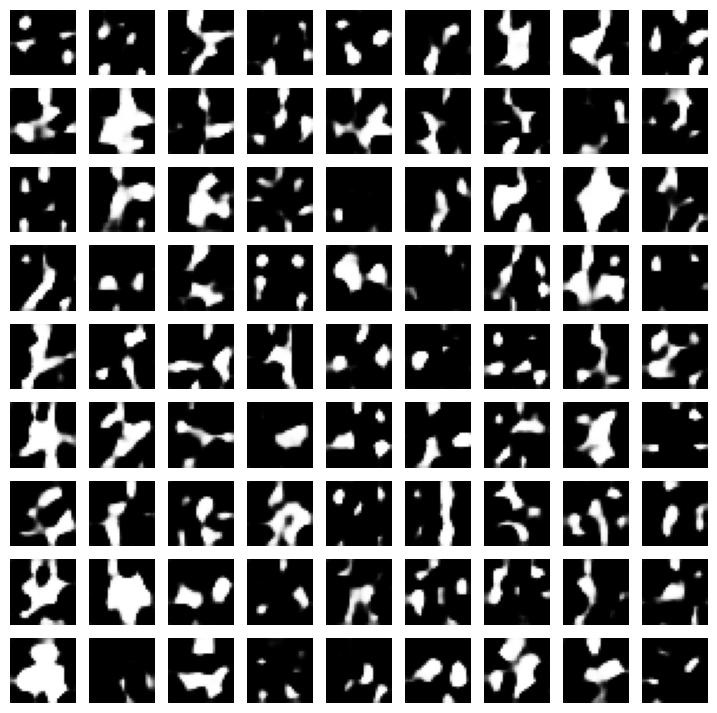

2025-09-15 09:12:42.559331: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


E:1, Loss G:3.3149, Loss D:0.1075, Acc G:%0.58, Acc D:%98.01
E:2, Loss G:2.7232, Loss D:0.1693, Acc G:%1.10, Acc D:%97.18


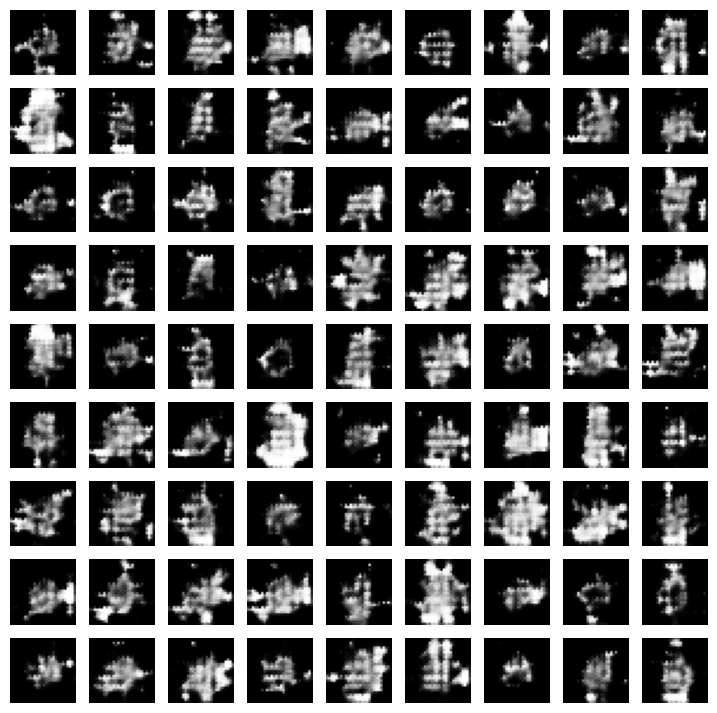

2025-09-15 09:13:55.185952: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


E:3, Loss G:2.2825, Loss D:0.2202, Acc G:%1.51, Acc D:%96.25
E:4, Loss G:1.9763, Loss D:0.2967, Acc G:%2.35, Acc D:%94.91


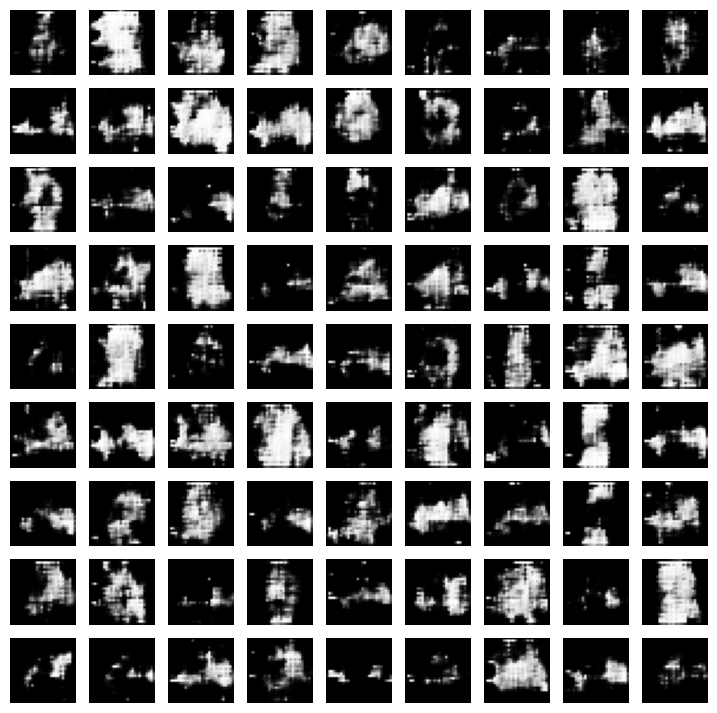

E:5, Loss G:2.0479, Loss D:0.2575, Acc G:%3.03, Acc D:%93.99
E:6, Loss G:1.8758, Loss D:0.3013, Acc G:%3.43, Acc D:%93.36


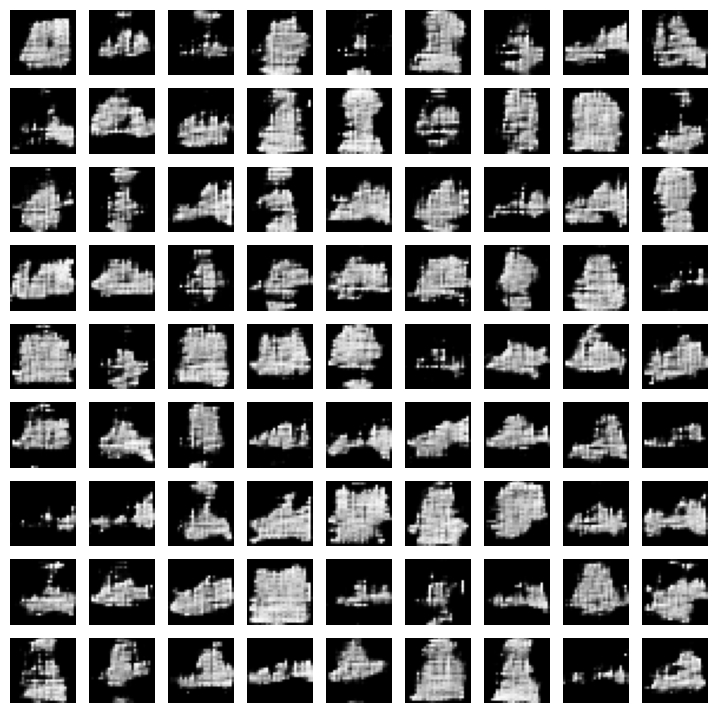

2025-09-15 09:16:20.567562: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


E:7, Loss G:1.8642, Loss D:0.2896, Acc G:%3.75, Acc D:%92.86
E:8, Loss G:1.8935, Loss D:0.2855, Acc G:%3.95, Acc D:%92.50


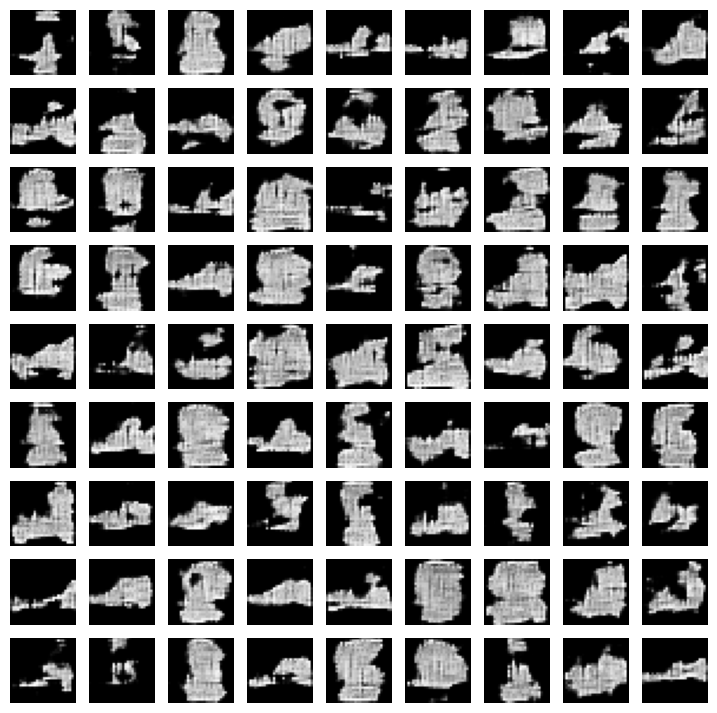

E:9, Loss G:1.8972, Loss D:0.2822, Acc G:%4.13, Acc D:%92.16
E:10, Loss G:2.0867, Loss D:0.2535, Acc G:%4.18, Acc D:%92.01


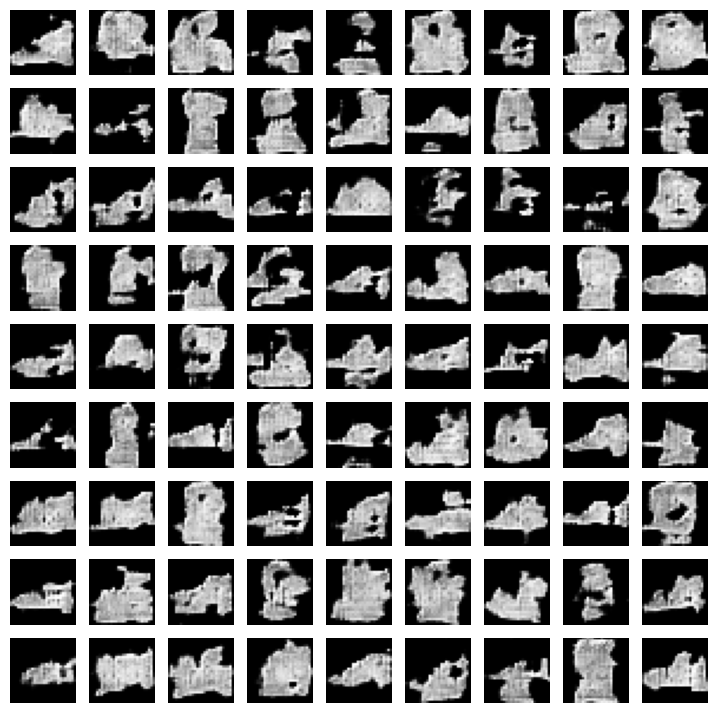

E:11, Loss G:2.1064, Loss D:0.2351, Acc G:%4.17, Acc D:%91.95
E:12, Loss G:2.1761, Loss D:0.2540, Acc G:%4.15, Acc D:%91.90


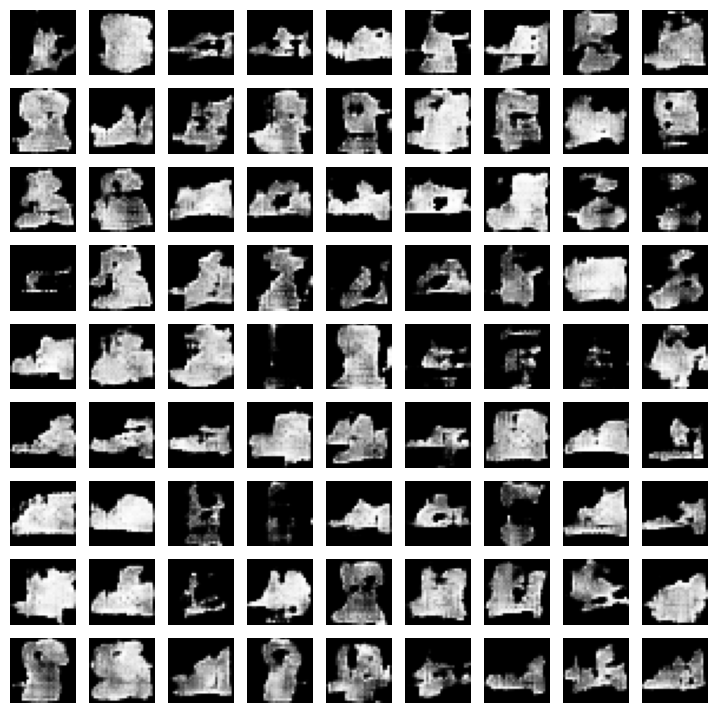

E:13, Loss G:2.0748, Loss D:0.2844, Acc G:%4.21, Acc D:%91.75
E:14, Loss G:2.0628, Loss D:0.2830, Acc G:%4.33, Acc D:%91.54


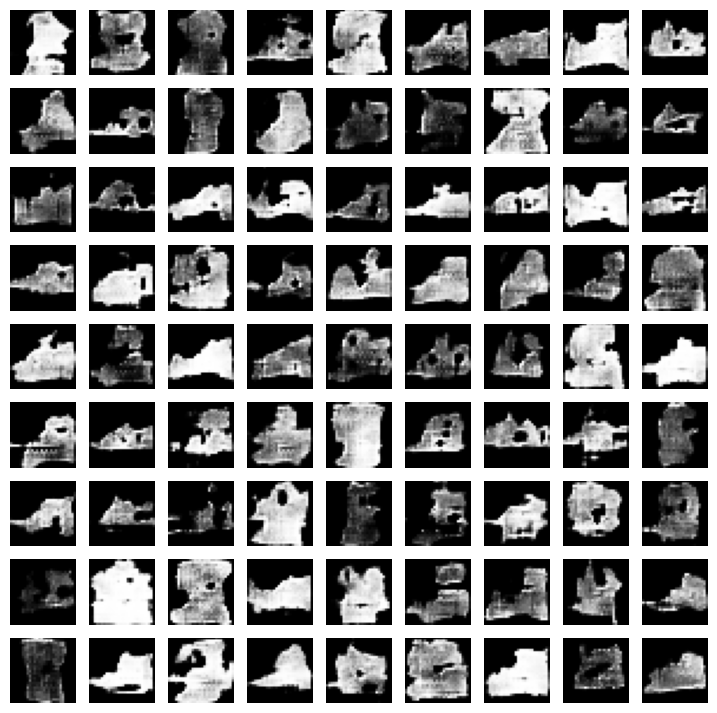

2025-09-15 09:21:11.739610: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


E:15, Loss G:2.0725, Loss D:0.2776, Acc G:%4.40, Acc D:%91.37
E:16, Loss G:2.0667, Loss D:0.2756, Acc G:%4.47, Acc D:%91.24


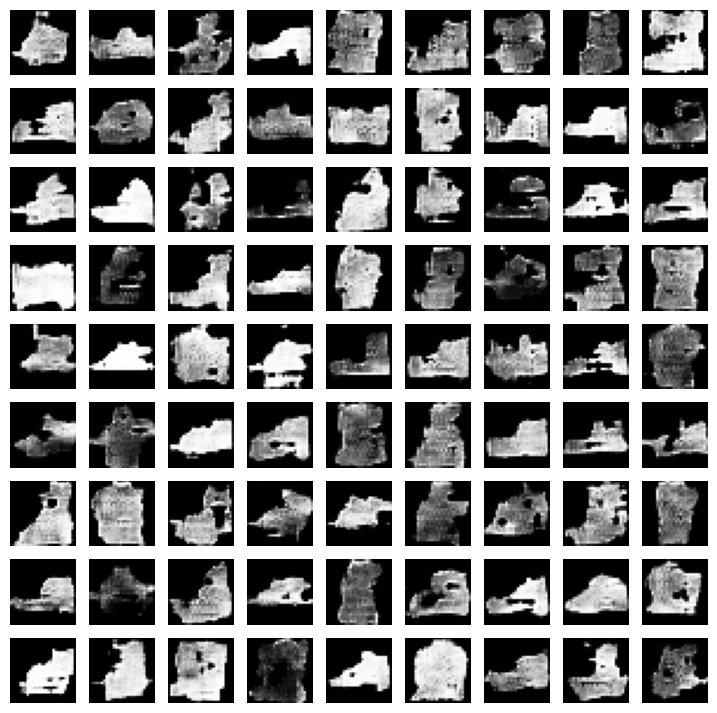

E:17, Loss G:2.0878, Loss D:0.2672, Acc G:%4.52, Acc D:%91.14
E:18, Loss G:2.0879, Loss D:0.2639, Acc G:%4.54, Acc D:%91.08


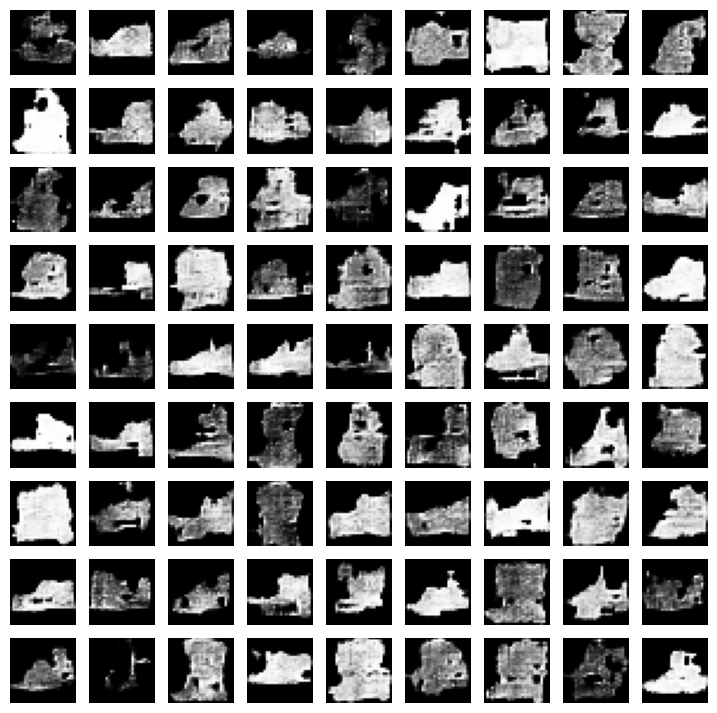

E:19, Loss G:2.0747, Loss D:0.2653, Acc G:%4.56, Acc D:%91.02
E:20, Loss G:2.0745, Loss D:0.2625, Acc G:%4.56, Acc D:%90.97


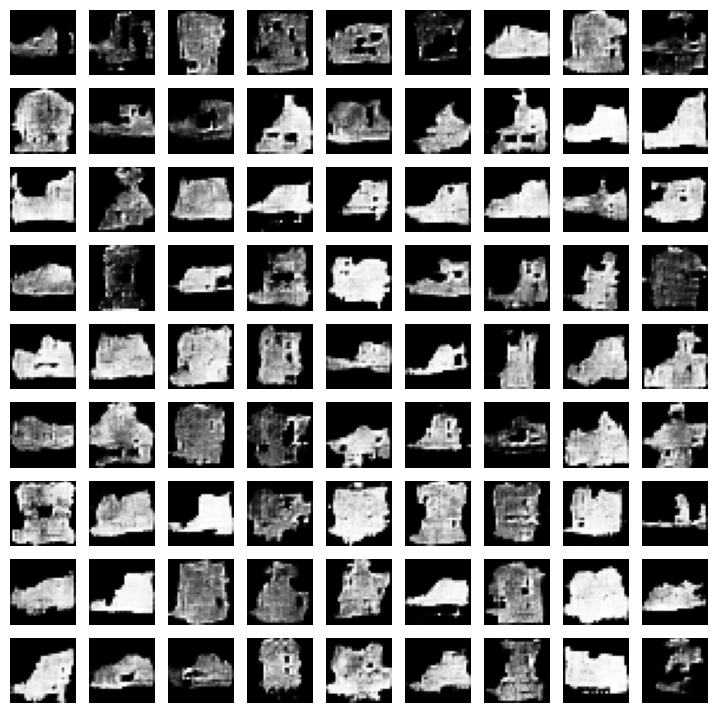

E:21, Loss G:2.0698, Loss D:0.2596, Acc G:%4.56, Acc D:%90.93
E:22, Loss G:2.0669, Loss D:0.2583, Acc G:%4.55, Acc D:%90.90


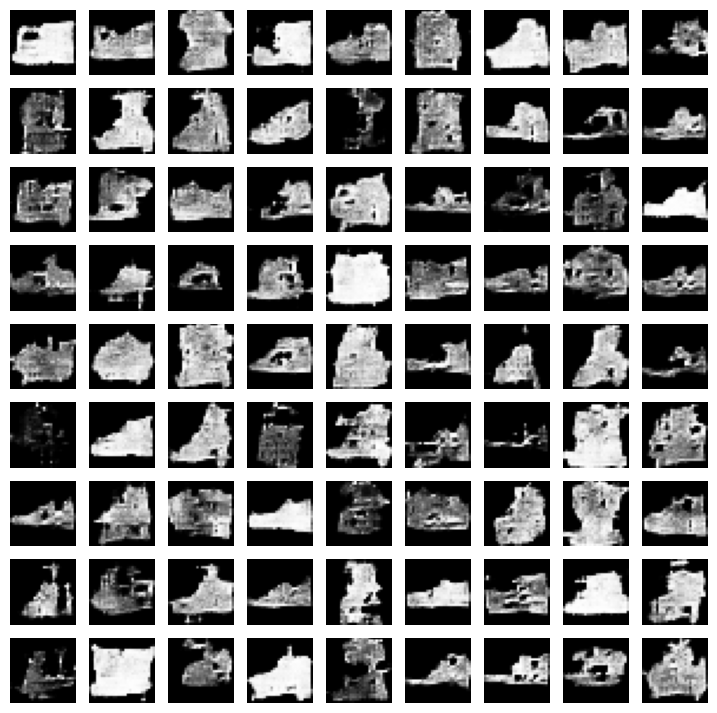

E:23, Loss G:2.0730, Loss D:0.2572, Acc G:%4.54, Acc D:%90.87
E:24, Loss G:2.0663, Loss D:0.2573, Acc G:%4.52, Acc D:%90.85


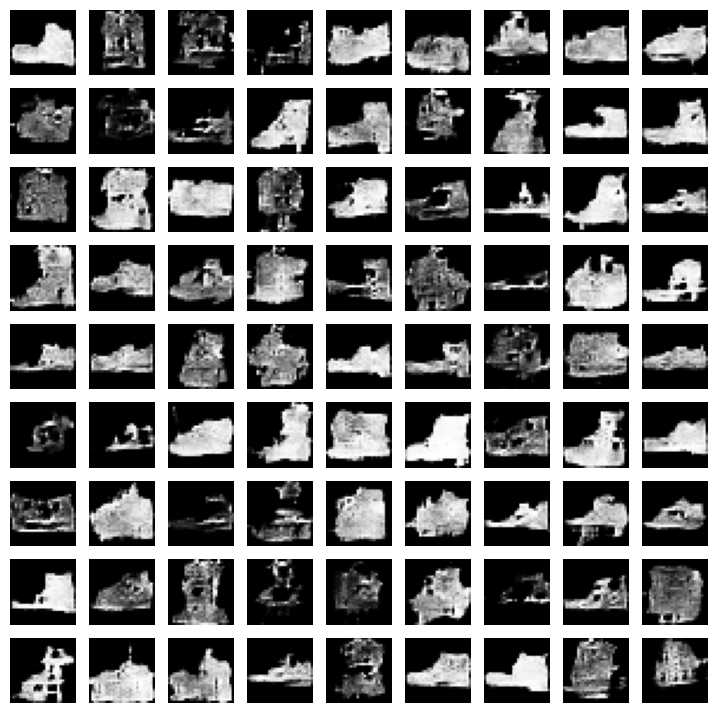

E:25, Loss G:2.0690, Loss D:0.2572, Acc G:%4.51, Acc D:%90.83
E:26, Loss G:2.0812, Loss D:0.2554, Acc G:%4.50, Acc D:%90.81


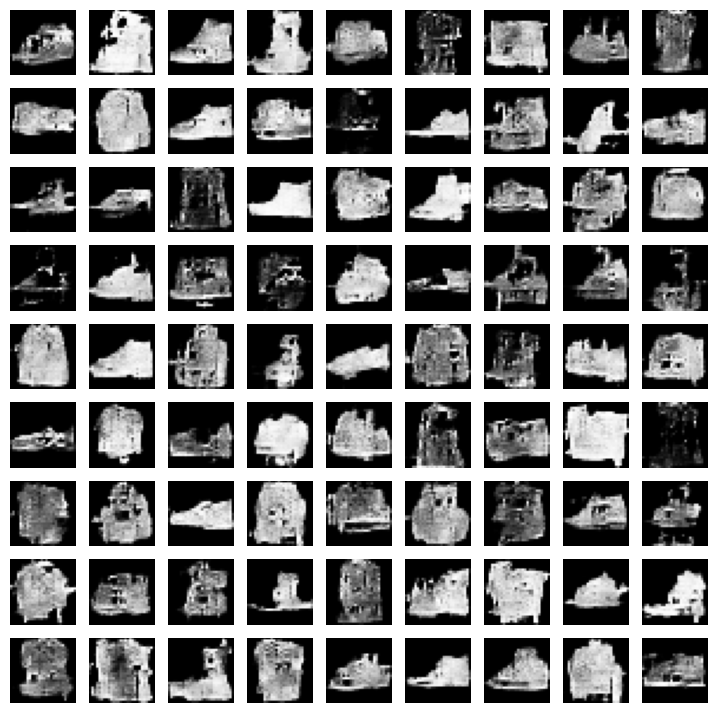

E:27, Loss G:2.0993, Loss D:0.2532, Acc G:%4.49, Acc D:%90.80
E:28, Loss G:2.1088, Loss D:0.2519, Acc G:%4.48, Acc D:%90.79


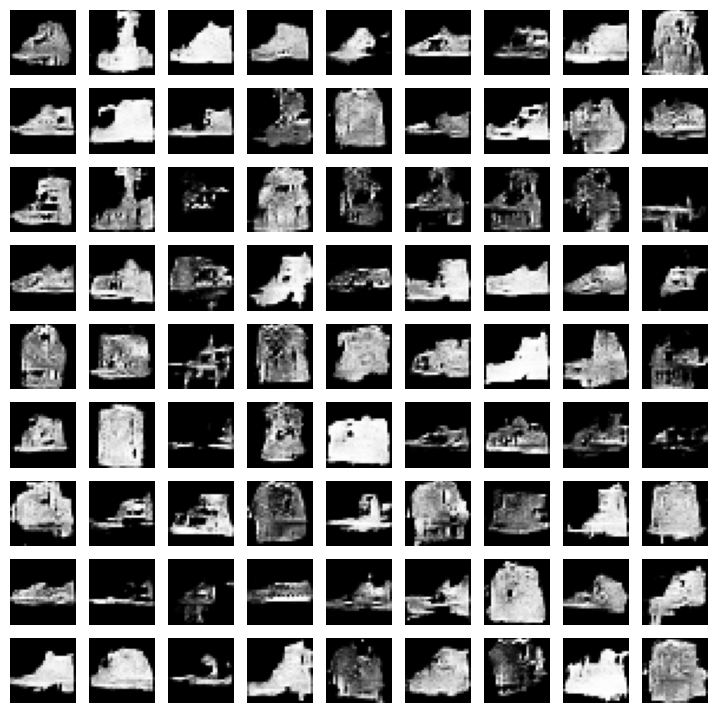

E:29, Loss G:2.1327, Loss D:0.2481, Acc G:%4.47, Acc D:%90.79


In [15]:
#30 epocas e cada iteração do treino é printado a loss e acuracia do discriminador e do gerador e também 91 imagens geradas pelo gerador
for epoch in range(30):

  dLossSum = 0
  gLossSum = 0
  dAccSum = 0
  gAccSum = 0
  cnt = 0

  for batch in dataset:
    dLoss = trainDStep(batch)
    dLossSum += dLoss['discriminator_loss']
    dAccSum += dLoss['discriminator_accuracy']
    gLoss = trainGStep(batch)
    gLossSum += gLoss['generator_loss']
    gAccSum += gLoss['generator_accuracy']

    cnt += 1

  print("E:{}, Loss G:{:0.4f}, Loss D:{:0.4f}, Acc G:%{:0.2f}, Acc D:%{:0.2f}".format(
      epoch,
      gLossSum/cnt,
      dLossSum/cnt,
      100 * gAccSum/cnt,
      100 * dAccSum/cnt
  ))
    
  if epoch % 2 == 0:
    plotImages(generator)

### Ver os resultados do treinamento da GAN

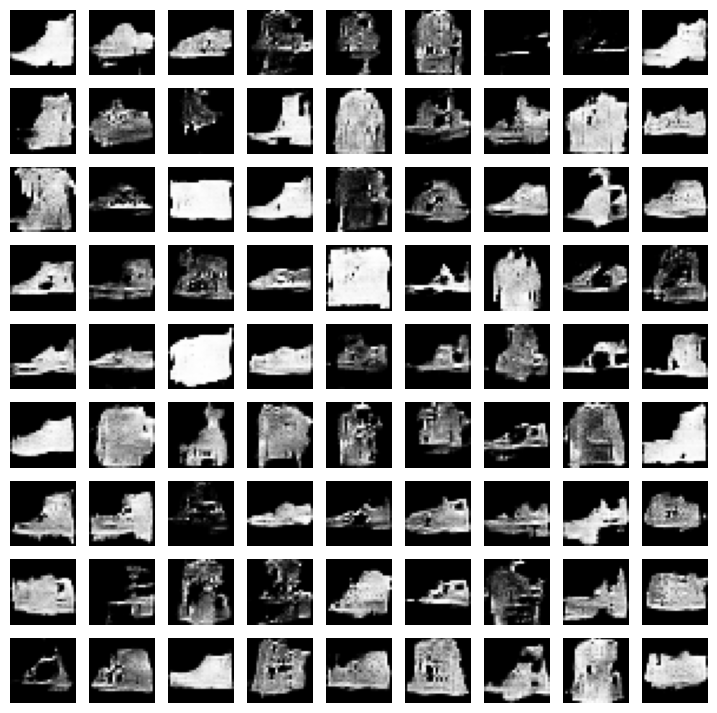

In [16]:
images = generator(np.random.normal(size=(81, NOISE_DIM)))

from matplotlib import pyplot as plt

plt.figure(figsize=(9, 9))

for i, image in enumerate(images):
    plt.subplot(9,9,i+1)
    plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
    plt.axis('off')

plt.show();